# Predicting the World Cup with the Google Cloud Platform

This notebook builds a machine learning model that can be used to predict professional soccer games. The notebook was created for the "Predicting the Future with the Google Cloud Platform" talk at Google I/O 2014 by Jordan Tigani and Felipe Hoffa. A link to the presentation is here: https://www.youtube.com/watch?v=YyvvxFeADh8

Once the machine learning model is built, we use it to predict outcomes in the World Cup.  If you are seeing this after the world cup is over, you can use it to predict hypothetical matchups (how would the 2010 World Cup winners do against the current champions?). You can also see how various different strategies would affect prediction outcomes. Maybe you'd like to add player salary data and see how that affects predictions (likely it will help a lot). Maybe you'd like to try Poisson Regression instead of Logistic Regression. Or maybe you'd like to try data coercion techniques like whitening or PCA.

The model uses Logistic Regression, built from touch-by-touch data about three different soccer leagues (English Premier League, Spainish La Liga, and American Major League Soccer) over multiple seasons. Because the data is licensed, only the aggregated statistics about those games are available. (If you have ideas of other statistics you'd like to see, create a new issue in the https://github.com/GoogleCloudPlatform/ipython-soccer-predictions GitHub repo and we'll see what we can do.) The match_stats.py file shows the raw queries that were used to generate the stats.

There are four python files that are used by this notebook. They must be in the path. These are:

* match_stats: Reads the match statistics from BigQuery. Because we are using the pre-aggregated data, most of the code here is disabled, but it is kept in order to show the data transformations that are done from the raw data in order to build the stats.
* features: Turns raw statistics into features that get fed into the machine learning model. These features combine statistics from the trailing N games to predict the next game. 
* world_cup: Helper methods for cleaning the data and building and running the logistic regression model.
* power: Computes a "power" statistic over a number of teams who have played against eachother, attempting to come up with a ranking.


## Setting up BigQuery Authentication

Since we're providing this notebook as part of a Docker image that can be run on Google Compute Engine, we'll override the authorization used in the Pandas BigQuery connector to use GCE auth. This will mean that you don't have to do any authorization on your own. You must, however, have the BigQuery API enabled in your Google Cloud Project (https://console.developers.google.com). Because the data sizes (after aggregation) are quite small, you may not need to enable billing.

In [1]:
from oauth2client.gce import AppAssertionCredentials
from bigquery_client import BigqueryClient
from pandas.io import gbq

def GetMetadata(path):
  import urllib2
  BASE_PATH = 'http://metadata/computeMetadata/v1/'
  request = urllib2.Request(BASE_PATH + path, headers={'Metadata-Flavor': 'Google'})
  return urllib2.urlopen(request).read()

credentials = AppAssertionCredentials(scope='https://www.googleapis.com/auth/bigquery')

client = BigqueryClient(credentials=credentials,
                        api='https://www.googleapis.com',
                        api_version='v2',
                        project_id=GetMetadata('project/project-id'))

gbq._authenticate = lambda: client

## Verifying setup
Loads the required modules and run a quick BigQuery query. This will test to make sure we have authentication and the pandas bigquery connector working correctly.

In [1]:
from pandas.io import gbq

# Import the four python modules that we use.
import match_stats
import features
import world_cup
import power
query = "SELECT * FROM (%(summary_query)s) LIMIT 1" % {
    'summary_query': match_stats.team_game_summary_query()}
gbq.read_gbq(query)

Waiting on bqjob_r337c26ad9dfd06bd_00000147233b4372_1 ... (0s) Current status: DONE   


matchid 
 teamid 
 passes 
 bad_passes 
 pass_ratio 
 corners 
 fouls 
 shots 
 cards 
 pass_80 
 pass_70 
 timestamp 
 goals 
 is_home 
 team_name 
 competitionid 
 seasonid 
 expected_goals 
 on_target 
 length 
 
 
 
 
 0 
 731825 
 838 
 2.111111 
 0.912698 
 0.696335 
 0.007937 
 0.119048 
 0.087302 
 4 
 0.02381 
 0.063492 
 1404604038607 
 0 
 0 
 Costa Rica 
 4 
 2013 
 0.254178 
 0.007937 
 126 
 
 
 
 1 rows × 20 columns

## Building features
This will return a pandas dataframe that contains the features that will be used to build a model.

The features query will read from the game summary table that has prepared per-game statistics that will be used to predict outcomes.
The data has been aggregated from touch-by-touch data from Opta. However, since that data is not public, we use these
prepared statistics instead of the raw data.

In order to predict a game, we look at the previous N games of history for each team, where N is defined here as history_size.

In [3]:
import features
reload(features)

# Sets the history size. This is how far back we will look before each game to aggregate statistics
# to predict the next game. For example, a history size of 5 will look at the previous 5 games played
# by a particular team in order to predict the next game.
history_size = 6

game_summaries = features.get_game_summaries()
data = features.get_features(history_size)

Waiting on bqjob_rdad0a47a2ca5106_0000014722ccfb80_2 ... (0s) Current status: DONE   
Waiting on bqjob_r61ce926a2f57863e_0000014722cd178a_3 ... (0s) Current status: DONE   

The features include rollups from the last K games. Most of them are averages that are computed per-minute of game time. Per-minute stats are used in order to be able to normalize for games in the world cup that go into overtime.

### Feature columns:
The following columns are the features that will be used to build the prediction model:

* is_home: Whether a team is playing at home or away. This turns out to be a big deal in soccer.
* avg_points: Average number of points (3 for a win, 1 for a draw, 0 for a loss) earned in the last K games.
* avg_goals: Average number of goals scored in the last K games.
* op_average_goals: Average number of goals scored by the opponent in the last K games.
* pass\_{70/80}: Number of completed passes per minute in the attacking 30%/20% of the field.
* op_pass\_{70/80}: Number of completed passes by the opponent in their attacking 30%/20% of the field.
* expected_goals: Average number of expected goals in the last K games, where expected goals is computed based on the number of shots taken and their distance from the goal.
* passes: Number of passes completed per minute.
* bad_passes: Number of passes that didn't complete successfully per minute.
* pass_ratio: Percentage of completed passes.
* corners: Number of corner kicks awareded per minute.
* fouls: Number of fouls committed per minute.
* cards: Number of cards recieved (red or yellow) per game.
* shots: Number of shots taken per minute.
* op\_\*: Statistics about the opponent in the historical games. This is not the opoonent shown in op_team_name; instead, these stats show how the primary team's opponents have fared against them. For example, op_corners is how many corners the teams opponents have been awarded per minute.
* \*\_op\_ratio: Ratio of a team's statistics to their opponents.

### Non-feature columns:
The following columns are included as metadata about the match:

* matchid: Unique id for the match
* teamid: Unique id for the team whose historical statistics we're looking at.
* op_teamid: Unique id for the opposing team. None of these statistics reflect this opponent.
* team_name: Name of the team whose historical statistics we're looking at.
* op_team_name: Name of the opposing team.
* timestamp: Time at which the game was played.
* competitionid: Unique id for the competition (separates MLS from FIFA World CUp from EPL).


### Target columns:
The following columns are target variables that we will be attempting to predict. These columns must be dropped before any prediction is done, but are useful when building a model. The models that we will build below will just try to predict outcome (points) but other models may choose to predict goals, which is why they are also included here.

* points: The outcome of the game. 3 points for a win, 1 point for a draw, 0 for a loss. (Points are not goals!)
* goals: The number of goals the team referenced by teamid scored.
* op_goals: The number of goals the team referenced by op_teamid scored.

In [4]:
# Partition the world cup data and the club data. We're only going to train our model using club data.

club_data = data[data['competitionid'] <> 4]
# Show the features latest game in competition id 4, which is the world cup.
data[data['competitionid'] == 4].iloc[0]

matchid                                  731828
teamid                                      366
op_teamid                                   632
competitionid                                 4
seasonid                                   2013
is_home                                       0
team_name                           Netherlands
op_team_name                          Argentina
timestamp            2014-07-09 21:00:00.000000
goals                                         0
op_goals                                      0
points                                        1
avg_points                             2.166667
avg_goals                                     2
op_avg_goals                          0.8333333
pass_70                                0.412262
pass_80                               0.1391892
op_pass_70                            0.3897345
op_pass_80                             0.114534
expected_goals                         1.799292
op_expected_goals                     0.

Compute the crosstabs for goals scored vs outcomes. Scoring more than 5 goals means you're guaranteed to win, and scoring no goals means you lose about 75% of the time (sometimes you tie!).

In [5]:
import pandas as pd
pd.crosstab(
    club_data['goals'], 
    club_data.replace(
        {'points': {
            0: 'lose', 1: 'tie', 3: 'win'}})['points'])

points 
 lose 
 tie 
 win 
 
 
 goals 
 
 
 
 
 
 
 
 0 
 727 
 267 
 0 
 
 
 1 
 477 
 394 
 320 
 
 
 2 
 131 
 205 
 500 
 
 
 3 
 21 
 40 
 314 
 
 
 4 
 2 
 6 
 148 
 
 
 5 
 0 
 2 
 65 
 
 
 6 
 0 
 0 
 12 
 
 
 7 
 0 
 0 
 6 
 
 
 8 
 0 
 0 
 1

## Training the model

We're going to train a logistic regression model based on the club data only. This will use an external code file world_cup.py to build the model.

The output of this cell this will be a logistic regression model and a test set that we can use to test how good we are at predicting outcomes.
The cell will also print out the Rsquared value for the regression. This is a measaure of how good the fit was to the model (higher is better).

In [6]:
import world_cup
reload(world_cup)
import match_stats
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Don't train on games that ended in a draw, since they have less signal.
train = club_data.loc[club_data['points'] <> 1] 
# train = club_data

(model, test) = world_cup.train_model(
     train, match_stats.get_non_feature_columns())
print "\nRsquared: %0.03g" % model.prsquared


Rsquared: 0.164


## Picking important features

The logistic regression model is built using regularization; this means that it penalizes complex models. It has the side effect of helping us with feature selection. Features that are not important will be dropped out of the model completely. 

We can divide the features into three buckets:

* Positive features: These features mean that a team is more likely to win.
* Negative features: These features mean that a team is less likely to win.
* Dropped features: These features aren't important, and if we included them in the model, we'd probably be overfitting.

In [7]:
def print_params(model, limit=None):    
    params = model.params.copy()
    params.sort(ascending=False)
    del params['intercept']
    
    if not limit:
        limit = len(params)

    print("Positive features")
    params.sort(ascending=False)
    print np.exp(params[[param > 0.001 for param in params]]).sub(1)[:limit]

    print("\nDropped features")
    print params[[param  == 0.0 for param in params]][:limit]

    print("\nNegative features")
    params.sort(ascending=True)
    print np.exp(params[[param < -0.001 for param in params]]).sub(1)[:limit]

print_params(model, 10)

Positive features
is_home                  0.712618
pass_70                  0.215699
opp_op_expected_goals    0.198712
opp_op_corners           0.180812
shots                    0.146956
opp_bad_passes           0.145576
op_passes                0.091629
expected_goals           0.079620
avg_points               0.075306
fouls                    0.047963
dtype: float64

Dropped features
op_avg_goals         0
goals_op_ratio       0
op_cards             0
op_bad_passes        0
op_shots             0
corners              0
cards                0
opp_pass_op_ratio    0
pass_ratio           0
passes               0
dtype: float64

Negative features
opp_pass_70          -0.177428
op_expected_goals    -0.165771
op_corners           -0.153125
opp_shots            -0.128127
bad_passes           -0.127077
opp_op_passes        -0.083938
opp_expected_goals   -0.073748
opp_avg_points       -0.070032
opp_fouls            -0.045768
opp_avg_goals        -0.020472
dtype: float64


## Predicting wins in club data

This cell uses the test set (which was not used during the creation of the model) to predict outcomes. We can a few of the predictions to see how well we did. We'll show 5 each from two buckets: cases where we got it right, and cases where we got it wrong. We can see if these make sense. When we display these, the home team is always on the left. 

For example, it might show that we predicted Manchester United playing at home beating Sunderland. This is completely reasonable and we'd expect that the outcome would be 3 points (a victory).

The columns of the output are:

* team_name: Home team
* op_team_name: Away team
* predicted: The percentage chance that we believe the home team will win.
* points: What actually happenned. 3 points for a win, 1 point for a draw, 0 points for a loss.

In [8]:
reload(world_cup)
results = world_cup.predict_model(model, test, 
    match_stats.get_non_feature_columns())

predictions = world_cup.extract_predictions(
    results.copy(), results['predicted'])

print 'Correct predictions:'
predictions[(predictions['predicted'] > 50) & (predictions['points'] == 3)][:5]

Correct predictions:


team_name 
 op_team_name 
 predicted 
 expected 
 winner 
 points 
 
 
 
 
 5 
 Vancouver Whitecaps 
 Portland Timbers 
 50.746754 
 Vancouver Whitecaps 
 Vancouver Whitecaps 
 3 
 
 
 23 
 Sporting Kansas City 
 Montreal Impact 
 71.255427 
 Sporting Kansas City 
 Sporting Kansas City 
 3 
 
 
 49 
 Real Madrid 
 Real Sociedad 
 70.565179 
 Real Madrid 
 Real Madrid 
 3 
 
 
 59 
 Real Betis 
 Levante 
 57.020318 
 Real Betis 
 Real Betis 
 3 
 
 
 65 
 Seattle Sounders FC 
 Montreal Impact 
 53.362012 
 Seattle Sounders FC 
 Seattle Sounders FC 
 3

In [9]:
print '\nIncorrect predictions:'
predictions[(predictions['predicted'] > 50) & (predictions['points'] < 3)][:5]


Incorrect predictions:


team_name 
 op_team_name 
 predicted 
 expected 
 winner 
 points 
 
 
 
 
 8 
 Sporting Kansas City 
 D.C. United 
 52.268257 
 Sporting Kansas City 
 D.C. United 
 0 
 
 
 17 
 Celta de Vigo 
 Valencia CF 
 53.402876 
 Celta de Vigo 
 Valencia CF 
 0 
 
 
 19 
 Real Madrid 
 Celta de Vigo 
 69.646704 
 Real Madrid 
 Celta de Vigo 
 0 
 
 
 28 
 Atlético de Madrid 
 Levante 
 63.517874 
 Atlético de Madrid 
 Levante 
 0 
 
 
 29 
 LA Galaxy 
 Colorado Rapids 
 55.278595 
 LA Galaxy 
 Colorado Rapids 
 0

## Validating our predictions

Next, we want to actually quantify how good our predictions are. We can compute the lift ("How much better are we doing than random chance?"), AUC (the area under the ROC curve) and plot the ROC curve. AUC is arguable the most interesting number, it ranges between 0.5 (your model is no better than dumb luck) and 1.0 (perfect prediction).

(3) Lift: 1.45 Auc: 0.745


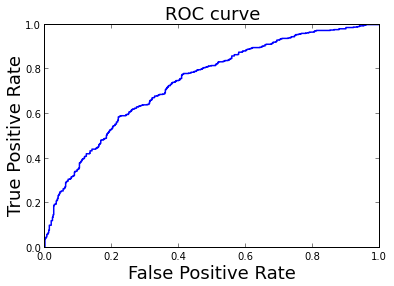

In [10]:
import pylab as pl
# Compute a baseline, which is the percentage of overall outcomes are actually wins.
# (remember in soccer we can have draws too).
baseline = (sum([yval == 3 for yval in club_data['points']]) 
            * 1.0 / len(club_data))
y = [yval == 3 for yval in test['points']]
world_cup.validate(3, y, results['predicted'], baseline, 
                   compute_auc=True)
pl.show()

# Need.... more .... power!

One thing that is missing, if you're predicting the next game based on the previous few games, is that some teams may have just played a really tough schedule, while other teams have played against much weaker competition.

We can solve for schedule difficulty by running another regression; this one computes a power ranking, similar to the FIFA/CocaCola power ranking for international soccer teams (there are power rankings for other sports like college (american) football that may be familiar.)

Once we compute the power ranking (which creates a stack ranking of all of the teams), we can add that power ranking as a feature to our model, then rebuild it and re-validate it. The regression essentailly automated the process of looking at relationships like "Well, team A beat team B and team B beat team C, so A is probably better than C".

The output here will show the power ranking for various teams. This can be useful to spot check the ranking, since if we rank Wiggan at 1.0 and Chelsea at 0.0, something is likely wrong. 

Note that because there isn't a strict ordering to the data (if team A beats team B and team B beats team C, sometimes team C will then beat team A) we sometimes fail to assign ordering to all of the teams (especially where the data is sparse). For teams that we can't rank, we put them in the middle (0.5).

Additionally, because the rankings for international teams are noisy and sparse, we chunk the rankings into quartiles. So teams that have been ranked will show up as 0, .33, .66, or 1.0.

Once we add this to the model, the performance generally improves significantly.

New season 2014
New season 2013


QC check did not pass for 19 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers


Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
New season 2013


New season 2012


QC check did not pass for 24 out of 24 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers


Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
New season 2012


New season 2011


QC check did not pass for 24 out of 24 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers


Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
[u'Blackburn Rovers: 0.000', u'Real Betis: 0.000', u'D.C. United: 0.000', u'Celta de Vigo: 0.004', u'Deportivo de La Coru\xf1a: 0.009', u'Wolverhampton Wanderers: 0.021', u'Reading: 0.022', u'Real Zaragoza: 0.026', u'Real Valladolid: 0.044', u'Granada CF: 0.062', u'Queens Park Rangers: 0.073', u'Mallorca: 0.089', u'Aston Villa: 0.092', u'Bolton Wanderers: 0.102', u'Osasuna: 0.109', u'Espanyol: 0.112', u'Wigan Athletic: 0.124', u'Sunderland: 0.130', u'Rayo Vallecano: 0.138', u'Almer\xeda: 0.145', u'Levante: 0.148', u'Elche: 0.154', u'Getafe: 0.170', u'Swansea City: 0.192', u'Southampton: 0.197', u'Norwich City: 0.206', u'Toronto FC: 0.211', u'Chivas USA: 0.218', u'West Ham United: 0.220', u'West Bromwich Albion: 0.224', u'Villarreal: 0.231', u'Stoke City: 0.255', u'Fulham: 0.274', u'Valencia: 0.296', u'Valencia CF: 0.296', u'M\xe1laga: 0.305', u'Newcastle United: 0.342', u'S



Rsquared: 0.238, Power Coef 2.22


(3) Lift: 1.48 Auc: 0.762


    Base: 0.375 Acc: 0.682 P(1|t): 0.742 P(0|f): 0.646
    Fp/Fn/Tp/Tn p/n/c: 100/228/288/416 516/516/1032
(old) Lift: 1.45 Auc: 0.745


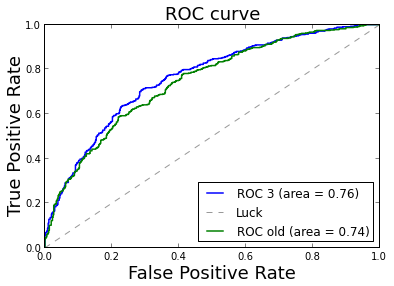

Positive features
power_points      1.222950
is_home           0.692184
pass_70           0.178619
op_passes         0.140863
fouls             0.138612
opp_op_corners    0.122122
opp_avg_points    0.055252
opp_op_fouls      0.039738
dtype: float64

Dropped features
avg_goals            0
op_bad_passes        0
corners              0
op_shots             0
op_cards             0
opp_pass_op_ratio    0
pass_ratio           0
passes               0
dtype: float64

Negative features
opp_power_points   -0.550147
opp_pass_70        -0.151549
opp_op_passes      -0.123470
opp_fouls          -0.121738
op_corners         -0.108831
avg_points         -0.052359
op_fouls           -0.038220
bad_passes         -0.028956
dtype: float64


In [11]:
import power
reload(power)
reload(world_cup)
def points_to_sgn(p):
  if p > 0.1: return 1.0
  elif p < -0.1: return -1.0
  else: return 0.0
power_cols = [
  ('points', points_to_sgn, 'points'),
]

power_data = power.add_power(club_data, game_summaries, power_cols)
power_train = power_data.loc[power_data['points'] <> 1] 

# power_train = power_data
(power_model, power_test) = world_cup.train_model(
    power_train, match_stats.get_non_feature_columns())
print "\nRsquared: %0.03g, Power Coef %0.03g" % (
    power_model.prsquared, 
    math.exp(power_model.params['power_points']))

power_results = world_cup.predict_model(power_model, power_test, 
    match_stats.get_non_feature_columns())
power_y = [yval == 3 for yval in power_test['points']]
world_cup.validate(3, power_y, power_results['predicted'], baseline, 
                   compute_auc=True, quiet=False)

pl.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
# Add the old model to the graph
world_cup.validate('old', y, results['predicted'], baseline, 
                   compute_auc=True, quiet=True)
pl.legend(loc="lower right")
pl.show()

print_params(power_model, 8)

## On to the world cup!

Now that we've got a model that we like, let's look at predicting the world cup. We can build the same statistics (features) for the world cup games that we did for the club games. In this case, however, we don't have the targets; that is, we don't know who won (for some of the previous games, we do know who won, but let's predict them all equally as if we didn't know).

features.get_wc_features() will return build features from the world cup games.

In [12]:
import world_cup
import features
reload(match_stats)
reload(features)
reload(world_cup)

wc_data = world_cup.prepare_data(features.get_wc_features(history_size))
wc_labeled = world_cup.prepare_data(features.get_features(history_size))
wc_labeled = wc_labeled[wc_labeled['competitionid'] == 4]
wc_power_train = game_summaries[game_summaries['competitionid'] == 4].copy()

Waiting on bqjob_r771c340a8483b8a6_0000014722cd55df_4 ... (0s) Current status: DONE   
Waiting on bqjob_r5df9ca3d043b572b_0000014722cd5dbe_5 ... (0s) Current status: DONE   

## Predicting the world cup

Once we have the model and the features, we can start predicting.

### Home Team Advantage
There are a couple of differences between the world cup and club data. For one, while home team advantage is important in club games, who is really at home? Is it only Brazil? What about other south american teams? Some models give the 'is home' status to only Brazil, others give partial status to other teams from the same continent, since historical data shows that teams from the same continent tend to outperform.

We use a slightly modified model that is, however, somewhat subjective. We assing a value to is_home between 0.0 to 1.0 depending on the fan support (both numbers and enthusiasm) that a team enjoys. This is a result of noticing, in the early rounds, that the teams that had the more entusiastic supporters did better. For example, Chile's fans were deafining in support of their team, but Spain's fans barely showed up (Chile upset spain 2-0). There were a number of other cases like this; many involving south american sides, but many involving other teams that had sent a lot of supporters (Mexico, for example). Some teams, like the USA, had a lot of fans, but they were more reserved... they got a lower score. This factor was set based on first-hand reports from the group games.


In [13]:
import pandas as pd
wc_home = pd.read_csv('wc_home.csv')

def add_home_override(df, home_map):
  for ii in xrange(len(df)):
    team = df.iloc[ii]['teamid']
    if team in home_map:
        df['is_home'].iloc[ii] = home_map[team]
    else:
        # If we don't know, assume not at home.
        df['is_home'].iloc[ii] = 0.0
        
home_override = {}
for ii in xrange(len(wc_home)):
    row = wc_home.iloc[ii]
    home_override[row['teamid']] = row['is_home']

# Add home team overrides.
add_home_override(wc_data, home_override)

### World Cup Power Rankings

The lattice of teams playing eachother in the world cup is pretty sparese. Many teams haven't played eachother for decades. Many European teams rarely play South American ones, and even more rarely play Asian ones. We can use the same technique as we did for the club games, but we have to be prepared for failure.

We'll output the power rankings from the previous games. We should eyeball them to make sure they make sense.

In [14]:
# When training power data, since the games span multiple competitions, just set is_home to 0.5
# Otherwise when we looked at games from the 2010 world cup, we'd think Brazil was still at
# home instead of South Africa.
wc_power_train['is_home'] = 0.5
wc_power_data = power.add_power(wc_data, wc_power_train, power_cols)

wc_results = world_cup.predict_model(power_model, wc_power_data, 
    match_stats.get_non_feature_columns())

New season 2013
New season 2009
New season 6


QC check did not pass for 45 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers


Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
[u'Australia: 0.000', u'USA: 0.017', u'Nigeria: 0.204', u"C\xf4te d'Ivoire: 0.244", u'Costa Rica: 0.254', u'Algeria: 0.267', u'Paraguay: 0.277', u'Greece: 0.284', u'Switzerland: 0.291', u'Ecuador: 0.342', u'Uruguay: 0.367', u'Japan: 0.406', u'Mexico: 0.409', u'Chile: 0.413', u'England: 0.460', u'Portugal: 0.487', u'Ghana: 0.519', u'France: 0.648', u'Spain: 0.736', u'Argentina: 0.793', u'Italy: 0.798', u'Brazil: 0.898', u'Netherlands: 0.918', u'Germany: 1.000']


### Predicting games

Now's the moment we've been waiting for. Let's predict some world cup games. Let's start with predicting the ones that have already happenned.

We will output 4 columns:

* team_name: Team we're predicting
* op_team_name: Team that the team we're predicting is playing against
* predicted: Precentage chance (we believe) that the team will win.
* points: If the game has been played, what actually happenned. (if the game hasn't been played, we'll show a NaN here). 3 points is a win, 1 point is a draw, 0 points is a loss. Note that for games in the knockout phase that went into penalty kicks, we'll mark that as a draw.

*But wait! These predictions are different from the ones you published!*

There are three reasons why the prediction numbers might be different from the numbers you may have seen as published predictions:

1. We've updated our code several times to fix bugs and improve accuracy. Our original model, for example, didn't account for extra time causing inflated statistics.
1. Model building is non-deterministic. Since we pick a random subset of the data to use as our training set, the results will change from run to run. Sometimes fairly significantly.
1. When we predicted the round of 16, we used the trailing 3 games to predict (since each team had played 3 games in the current world cup). For the quarterfinals, we used the trailing 4 games; for the semis, 5, and for the finals, we used all 6. The code below will predict based on the last 6 games; for many teams, we don't have 6 games of history, and even if we do, that history will be from previous world cups. *To see a more apples-to-apples comparison, set the history_size variable to 3 and rerun the notebook.*


In [15]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

wc_with_points = wc_power_data.copy()
wc_with_points.index = pd.Index(
    zip(wc_with_points['matchid'], wc_with_points['teamid']))
wc_labeled.index = pd.Index(
    zip(wc_labeled['matchid'], wc_labeled['teamid']))
wc_with_points['points'] = wc_labeled['points']

wc_pred = world_cup.extract_predictions(wc_with_points, 
                                        wc_results['predicted'])

# Reverse our predictions to show the most recent first.
wc_pred.reindex(index=wc_pred.index[::-1])
# Show our predictions for the games that have already happenned.
wc_pred[wc_pred['points'] >= 0.0]

team_name 
 op_team_name 
 predicted 
 expected 
 winner 
 points 
 
 
 
 
 2 
 Netherlands 
 Argentina 
 45.187866 
 Argentina 
 draw 
 1 
 
 
 3 
 Germany 
 Brazil 
 46.087340 
 Brazil 
 Germany 
 3 
 
 
 4 
 Costa Rica 
 Netherlands 
 20.699193 
 Netherlands 
 draw 
 1 
 
 
 5 
 Germany 
 France 
 70.918295 
 Germany 
 Germany 
 3 
 
 
 6 
 Switzerland 
 Argentina 
 13.489369 
 Argentina 
 Argentina 
 0 
 
 
 7 
 Algeria 
 Germany 
 5.281820 
 Germany 
 Germany 
 0 
 
 
 8 
 Nigeria 
 France 
 6.469553 
 France 
 France 
 0 
 
 
 9 
 Greece 
 Costa Rica 
 44.465888 
 Costa Rica 
 draw 
 1 
 
 
 10 
 Mexico 
 Netherlands 
 25.852847 
 Netherlands 
 Netherlands 
 0 
 
 
 11 
 Chile 
 Brazil 
 29.159847 
 Brazil 
 draw 
 1 
 
 
 12 
 Germany 
 USA 
 92.599808 
 Germany 
 Germany 
 3 
 
 
 13 
 Ghana 
 Portugal 
 49.394952 
 Portugal 
 Portugal 
 0 
 
 
 14 
 France 
 Ecuador 
 84.520092 
 France 
 draw 
 1 
 
 
 15 
 Uruguay 
 Italy 
 24.142942 
 Italy 
 Uruguay 
 3 
 
 
 16 
 Spain 
 Australia 
 92.766946 
 Spain 
 Spain 
 3 
 
 
 17 
 Chile 
 Netherlands 
 36.429691 
 Netherlands 
 Netherlands 
 0 
 
 
 18 
 Portugal 
 USA 
 73.875672 
 Portugal 
 draw 
 1 
 
 
 19 
 Ghana 
 Germany 
 14.933490 
 Germany 
 draw 
 1 
 
 
 20 
 France 
 Switzerland 
 84.456472 
 France 
 France 
 3 
 
 
 21 
 England 
 Uruguay 
 61.402920 
 England 
 Uruguay 
 0 
 
 
 22 
 Netherlands 
 Australia 
 90.897030 
 Netherlands 
 Netherlands 
 3 
 
 
 23 
 Mexico 
 Brazil 
 18.745963 
 Brazil 
 draw 
 1 
 
 
 24 
 USA 
 Ghana 
 29.331909 
 Ghana 
 USA 
 3 
 
 
 25 
 Portugal 
 Germany 
 15.955012 
 Germany 
 Germany 
 0 
 
 
 26 
 Japan 
 Côte d'Ivoire 
 41.934990 
 Côte d'Ivoire 
 Côte d'Ivoire 
 0 
 
 
 27 
 Italy 
 England 
 73.812329 
 Italy 
 Italy 
 3 
 
 
 28 
 Netherlands 
 Spain 
 49.682892 
 Spain 
 Netherlands 
 3 
 
 
 29 
 Spain 
 Netherlands 
 53.295771 
 Spain 
 Spain 
 3 
 
 
 30 
 Germany 
 Uruguay 
 78.982270 
 Germany 
 Germany 
 3 
 
 
 31 
 Spain 
 Germany 
 41.830024 
 Germany 
 Spain 
 3 
 
 
 32 
 Spain 
 Paraguay 
 89.878445 
 Spain 
 Spain 
 3 
 
 
 33 
 Germany 
 Argentina 
 45.202720 
 Argentina 
 Germany 
 3 
 
 
 34 
 Brazil 
 Netherlands 
 63.908731 
 Brazil 
 Netherlands 
 0 
 
 
 35 
 Portugal 
 Spain 
 20.960764 
 Spain 
 Spain 
 0 
 
 
 36 
 Japan 
 Paraguay 
 63.519259 
 Japan 
 draw 
 1 
 
 
 37 
 Mexico 
 Argentina 
 27.152356 
 Argentina 
 Argentina 
 0 
 
 
 38 
 England 
 Germany 
 17.248992 
 Germany 
 Germany 
 0 
 
 
 39 
 Ghana 
 USA 
 70.933824 
 Ghana 
 Ghana 
 3 
 
 
 40 
 Brazil 
 Portugal 
 88.601369 
 Brazil 
 draw 
 1 
 
 
 41 
 Germany 
 Ghana 
 89.953475 
 Germany 
 Germany 
 3 
 
 
 42 
 France 
 Italy 
 39.809571 
 Italy 
 draw 
 1 
 
 
 43 
 Portugal 
 Germany 
 12.435939 
 Germany 
 Germany 
 0

Let's look at the stats for the teams in the final. We can compare them by eyeball to see which one we think will win:

In [16]:
final = wc_power_data[wc_power_data['matchid'] == '731830']
final

matchid 
 teamid 
 op_teamid 
 competitionid 
 seasonid 
 is_home 
 team_name 
 op_team_name 
 timestamp 
 avg_points 
 avg_goals 
 op_avg_goals 
 pass_70 
 pass_80 
 op_pass_70 
 op_pass_80 
 expected_goals 
 op_expected_goals 
 passes 
 bad_passes 
 pass_ratio 
 corners 
 fouls 
 cards 
 shots 
 op_passes 
 op_bad_passes 
 op_corners 
 op_fouls 
 op_cards 
 op_shots 
 goals_op_ratio 
 shots_op_ratio 
 pass_op_ratio 
 power_points 
 
 
 
 
 0 
 731830 
 632 
 357 
 4 
 2013 
 0.7 
 Argentina 
 Germany 
 2014-07-13 20:00:00.000000 
 2.666667 
 1.333333 
 0.500000 
 0.531302 
 0.173338 
 0.410517 
 0.141505 
 1.27091 
 0.703133 
 4.643395 
 0.954973 
 0.823198 
 0.070890 
 0.162126 
 1.000000 
 0.163520 
 3.179610 
 0.924281 
 0.047631 
 0.096118 
 1.833333 
 0.118528 
 1.083333 
 1.475854 
 1.110942 
 0.792664 
 
 
 1 
 731830 
 357 
 632 
 4 
 2013 
 0.2 
 Germany 
 Argentina 
 2014-07-13 20:00:00.000000 
 2.666667 
 2.833333 
 0.666667 
 0.808822 
 0.248188 
 0.427337 
 0.166366 
 2.11032 
 1.000115 
 5.643403 
 1.030747 
 0.837985 
 0.053194 
 0.152780 
 0.666667 
 0.147986 
 3.623266 
 1.008787 
 0.047043 
 0.122868 
 1.166667 
 0.132571 
 2.666667 
 1.525363 
 1.086513 
 1.000000

Now let's look at the games that made up the decisions:

In [17]:
op = game_summaries

def countryStats(d, name):
  pred = d['team_name'] == name
  return d[pred]

fr = countryStats(op, 'France')
ge = countryStats(op, 'Germany')
ar = countryStats(op, 'Argentina')
br = countryStats(op, 'Brazil')
ne = countryStats(op, 'Netherlands')
ge[:6]

matchid 
 teamid 
 passes 
 bad_passes 
 pass_ratio 
 corners 
 fouls 
 cards 
 goals 
 shots 
 is_home 
 team_name 
 pass_80 
 pass_70 
 expected_goals 
 on_target 
 length 
 op_teamid 
 op_passes 
 op_bad_passes 
 op_pass_ratio 
 op_corners 
 op_fouls 
 op_cards 
 op_goals 
 op_shots 
 op_team_name 
 op_pass_80 
 op_pass_70 
 op_expected_goals 
 op_on_target 
 competitionid 
 seasonid 
 shots_op_ratio 
 goals_op_ratio 
 pass_op_ratio 
 points 
 timestamp 
 
 
 
 
 3 
 731827 
 357 
 5.098901 
 0.989011 
 0.836036 
 0.054945 
 0.120879 
 0 
 7 
 0.153846 
 0 
 Germany 
 0.384615 
 0.912088 
 3.358086 
 0.109890 
 91 
 614 
 4.494505 
 0.934066 
 0.826263 
 0.076923 
 0.153846 
 1 
 1 
 0.197802 
 Brazil 
 0.318681 
 0.736264 
 1.846013 
 0.087912 
 4 
 2013 
 0.777778 
 7 
 1.011828 
 3 
 1404859864586 
 
 
 29 
 731824 
 357 
 3.670213 
 1.223404 
 0.748373 
 0.031915 
 0.159574 
 2 
 1 
 0.095745 
 0 
 Germany 
 0.095745 
 0.489362 
 0.937786 
 0.031915 
 94 
 368 
 3.627660 
 1.170213 
 0.754425 
 0.053191 
 0.191489 
 0 
 0 
 0.138298 
 France 
 0.234043 
 0.382979 
 1.199728 
 0.053191 
 4 
 2013 
 0.692308 
 1 
 0.991978 
 3 
 1404500184917 
 
 
 38 
 731820 
 357 
 6.000000 
 1.147541 
 0.838488 
 0.081967 
 0.163934 
 1 
 2 
 0.229508 
 1 
 Germany 
 0.213115 
 0.713115 
 3.414730 
 0.098361 
 122 
 1215 
 2.467213 
 1.254098 
 0.661538 
 0.032787 
 0.090164 
 1 
 1 
 0.081967 
 Algeria 
 0.057377 
 0.172131 
 1.044178 
 0.032787 
 4 
 2013 
 2.800000 
 2 
 1.267482 
 3 
 1404171338462 
 
 
 74 
 731811 
 357 
 7.574468 
 0.861702 
 0.896725 
 0.031915 
 0.159574 
 1 
 1 
 0.138298 
 0 
 Germany 
 0.308511 
 1.180851 
 1.156981 
 0.063830 
 94 
 596 
 3.526882 
 0.795699 
 0.813896 
 0.021505 
 0.096774 
 2 
 0 
 0.043011 
 USA 
 0.118280 
 0.376344 
 0.000000 
 0.000000 
 4 
 2013 
 3.215426 
 1 
 1.101769 
 3 
 1403808875580 
 
 
 111 
 731795 
 357 
 5.989362 
 1.127660 
 0.840299 
 0.074468 
 0.180851 
 0 
 2 
 0.127660 
 1 
 Germany 
 0.223404 
 0.755319 
 1.511423 
 0.042553 
 94 
 1219 
 3.425532 
 1.074468 
 0.759434 
 0.031915 
 0.117021 
 1 
 2 
 0.191489 
 Ghana 
 0.148936 
 0.478723 
 1.337382 
 0.063830 
 4 
 2013 
 0.666667 
 1 
 1.106480 
 1 
 1403387662729 
 
 
 143 
 731779 
 357 
 5.527473 
 0.835165 
 0.867990 
 0.043956 
 0.131868 
 0 
 4 
 0.142857 
 1 
 Germany 
 0.263736 
 0.802198 
 2.282916 
 0.054945 
 91 
 359 
 4.197802 
 0.824176 
 0.834973 
 0.065934 
 0.087912 
 2 
 0 
 0.142857 
 Portugal 
 0.120879 
 0.417582 
 0.573390 
 0.032967 
 4 
 2013 
 1.000000 
 4 
 1.039543 
 3 
 1402944761781

OK now that we've looked at the data every which way possible, let's predict the final results:

In [18]:
wc_pred[~(wc_pred['points'] >= 0)][[
    'team_name', 'op_team_name', 'predicted']]

team_name 
 op_team_name 
 predicted 
 
 
 
 
 0 
 Argentina 
 Germany 
 43.224980 
 
 
 1 
 Netherlands 
 Brazil 
 37.168067